# Assignment 2: Web Scraping

## Q1. Scrape Book Catalog 
- Scape content of http://books.toscrape.com 
- Write a function getData() to scrape **title** (see (1) in Figure), **rating** (see (2) in Figure), **price** (see (3) in Figure) of all books (i.e. 20 books) listed in the page.
  * For example, the figure shows one book and the corresponding html code. You need to scrape the highlighted content. 
  * For star ratings, you can simply scrape One, Two, Three, ... 
- The output is a list of 20 tuples, e.g. [('A Light in the ...','Three','£51.77'), ...] 
    <img src='assign3_q1.png' width='80%'>


## Q2. Data Analysis 
- Create a function preprocess_data which 
  * takes the list of tuples from Q1 as an input
  * converts the price strings to numbers 
  * calculates the average price of books by ratings 
  * plots a bar chart to show the average price by ratings. 

### Q3 (Bonus) Expand your solution to Q1 to scrape the full details of all books on http://books.toscrape.com
- Write a function getFullData() to do the following: 
   * Besides scraping title, rating, and price of each book as stated in Q1, also scrape the **full title** (see (4) in Figure), **description** (see (5) in Figure), and **category** (see (6) in Figure) in each individual book page. 
     * An example individual book page is shown in the figure below.
       <img src='assign3_q3a.png' width='60%'>
   
   * Scape all book listing pages following the "next" link at the bottom. The figure below gives an screenshot of the "next" link and its corresponding html code. 
   * <b>Do not hardcode page URLs </b>(except http://books.toscrape.com) in your code. 
      <img src='assign3_q3.png' width='80%'>
   * The output is a list containing 1000 tuples, 
     - e.g. [('A Light in the ...','Three','£51.77', 'A Light in the Attic', "It's hard to imagine a world without A Light in the Attic. This now-classic collection ...",'Poetry'), ...]
    

In [1]:
import requests
from bs4 import BeautifulSoup  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions 


def preprocess_data(data):
    df = pd.DataFrame(data,columns = ['title','rating','price'] )
    df['price'] = [float(i[-5:]) for i in df['price']]
    grouped = df.groupby('rating')
    group_df = grouped.mean().reset_index()
    group_df.plot(kind = 'bar',x = 'rating',y = ['price'])
    plt.ylabel('average price')
    plt.title('average price by rating')
    plt.show()
    
def getData():
    url = 'http://books.toscrape.com'
    page = requests.get(url)
    if page.status_code==200:        
        soup = BeautifulSoup(page.content, 'html.parser')
        
    title = [i.string for i in soup.select('article h3')]
    rating = [i['class'][1] for i in soup.select('article p[class~=star-rating]')]
    price = [str(i)[-10:-4] for i in soup.select('article p[class=price_color]')] 
    array = np.array([title,rating,price]).T
    result_list = array.tolist()
    data=[tuple(i) for i in result_list]
    df = pd.DataFrame(array,columns = ['title','rating','price'] )
    print(len(title))
    print(df)   
    return data

def getFullData():
    
    # Set initial variable
    url = 'http://books.toscrape.com/catalogue/page-1.html'
    executable_path = '/Users/lilinsen/geckodriver'
    page_num = 1
    #page_total = int(soup.select('ul li[class=current]')[0].string.strip()[-2:])
    page_total = 50
    title = []
    rating = []
    price = []
    full_title = []
    description_s = [] 
    category_s = []
    while page_num < page_total:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        urls = ['http://books.toscrape.com/catalogue/'+i['href'] for i in soup.select('article div a[href]')]
        description = []
        category = []
        for u in urls:
            new_page = requests.get(u)
            new_soup = BeautifulSoup(new_page.content, 'html.parser')
            des = new_soup.select('article p')[3].string
            cate = new_soup.select('li a')[2].string
            description.append(des)
            category.append(cate)
        
        # Get the imformation of the book from each page
        description_s += description
        category_s += category
        title += [i.string for i in soup.select('article h3')]
        rating += [i['class'][1] for i in soup.select('article p[class~=star-rating]')]
        price += [str(i)[-10:-4] for i in soup.select('article p[class=price_color]')] 
        full_title += [i['title'].strip() for i in soup.select('article h3 a')]
    
        # Click on the next page and update the new url and page number
        driver = webdriver.Firefox(executable_path=executable_path)
        driver.get(url)
        try:
            next_link = driver.find_element_by_link_text('next')
            next_link.click()
            url = driver.current_url
            page_num = int(soup.select('ul li[class=current]')[0].string.strip()[5:7].strip())
            driver.quit()
        except:
            driver.quit()
            break
    # Get the tuple list
    array = np.array([title,rating,price,full_title,description_s,category_s ]).T
    result_list = array.tolist()
    data = [tuple(i) for i in result_list]         
    return data
    

20
                                    title rating   price
0                      A Light in the ...  Three  £51.77
1                      Tipping the Velvet    One  £53.74
2                              Soumission    One  £50.10
3                           Sharp Objects   Four  £47.82
4            Sapiens: A Brief History ...   Five  £54.23
5                         The Requiem Red    One  £22.65
6            The Dirty Little Secrets ...   Four  £33.34
7                 The Coming Woman: A ...  Three  £17.93
8                     The Boys in the ...   Four  £22.60
9                         The Black Maria    One  £52.15
10  Starving Hearts (Triangular Trade ...    Two  £13.99
11                  Shakespeare's Sonnets   Four  £20.66
12                            Set Me Free   Five  £17.46
13    Scott Pilgrim's Precious Little ...   Five  £52.29
14                      Rip it Up and ...   Five  £35.02
15                  Our Band Could Be ...  Three  £57.25
16                          

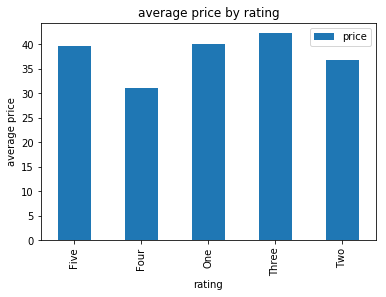

1000
('Girl Online On Tour ...', 'One', '£53.47', 'Girl Online On Tour (Girl Online #2)', "The sequel to the number-one bestseller Girl Online. Penny joins her rock-star boyfriend, Noah, on his European music tour.Penny's bags are packed.When Noah invites Penny on his European music tour, she can't wait to spend time with her rock-god-tastic boyfriend.But, between Noah's jam-packed schedule, less-than-welcoming bandmates and threatening messages from jealous fan The sequel to the number-one bestseller Girl Online. Penny joins her rock-star boyfriend, Noah, on his European music tour.Penny's bags are packed.When Noah invites Penny on his European music tour, she can't wait to spend time with her rock-god-tastic boyfriend.But, between Noah's jam-packed schedule, less-than-welcoming bandmates and threatening messages from jealous fans, Penny wonders whether she's really cut out for life on tour. She can't help but miss her family, her best friend Elliot . . . and her blog, Girl Online.Can

In [2]:
if __name__ == "__main__":  
    
    # Test Q1
    data=getData()
    
    # Test Q2
    preprocess_data(data)
    
    # Test Q3
    data=getFullData()
    print(len(data))
    
    # randomly select one book
    print(data[899])

# The result given by instructor

20
                                    title rating  price
0                      A Light in the ...  Three  51.77
1                      Tipping the Velvet    One  53.74
2                              Soumission    One  50.10
3                           Sharp Objects   Four  47.82
4            Sapiens: A Brief History ...   Five  54.23
5                         The Requiem Red    One  22.65
6            The Dirty Little Secrets ...   Four  33.34
7                 The Coming Woman: A ...  Three  17.93
8                     The Boys in the ...   Four  22.60
9                         The Black Maria    One  52.15
10  Starving Hearts (Triangular Trade ...    Two  13.99
11                  Shakespeare's Sonnets   Four  20.66
12                            Set Me Free   Five  17.46
13    Scott Pilgrim's Precious Little ...   Five  52.29
14                      Rip it Up and ...   Five  35.02
15                  Our Band Could Be ...  Three  57.25
16                                   Olio    

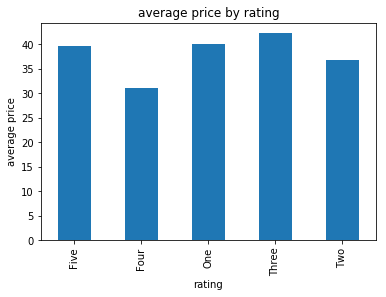

In [2]:
if __name__ == "__main__":  
    
    # Test Q1
    data=getData()
    
    # Test Q2
    preprocess_data(data)
    
    # Test Q3
    data=getFullData()
    print(len(data))
    
    # randomly select one book
    print(data[899])


1000
('Girl Online On Tour ...', 'One', '£53.47', 'Girl Online On Tour (Girl Online #2)', "The sequel to the number-one bestseller Girl Online. Penny joins her rock-star boyfriend, Noah, on his European music tour.Penny's bags are packed.When Noah invites Penny on his European music tour, she can't wait to spend time with her rock-god-tastic boyfriend.But, between Noah's jam-packed schedule, less-than-welcoming bandmates and threatening messages from jealous fan The sequel to the number-one bestseller Girl Online. Penny joins her rock-star boyfriend, Noah, on his European music tour.Penny's bags are packed.When Noah invites Penny on his European music tour, she can't wait to spend time with her rock-god-tastic boyfriend.But, between Noah's jam-packed schedule, less-than-welcoming bandmates and threatening messages from jealous fans, Penny wonders whether she's really cut out for life on tour. She can't help but miss her family, her best friend Elliot . . . and her blog, Girl Online.Can